## 1. Import Libraries

In [1]:
%pip install pandas matplotlib seaborn folium

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import json
import os

# Get the directory where this notebook is located
try:
    # For Jupyter notebooks
    script_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # __file__ is not defined in Jupyter, use current working directory
    script_dir = os.getcwd()

## 2. Load the Dataset

In [3]:
df = pd.read_csv(r"C:\Users\ghass\OneDrive\Desktop\practice projects\tutoré\scrape med data\cleaned_doctor_profiles_info2.csv", on_bad_lines='skip')

## 3. Data Preprocessing & Cleaning

In [4]:
print("\n--- Data Info ---")
print(df.info())


--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330 entries, 0 to 1329
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url            1330 non-null   object 
 1   name           1330 non-null   object 
 2   specialty      1330 non-null   object 
 3   phone1         1330 non-null   object 
 4   phone2         1330 non-null   object 
 5   address        1330 non-null   object 
 6   x              1330 non-null   float64
 7   y              1330 non-null   float64
 8   presentation   1330 non-null   object 
 9   working_hours  1330 non-null   object 
dtypes: float64(2), object(8)
memory usage: 104.0+ KB
None


In [5]:
# Clean the 'specialty' column (removing whitespace)
df['specialty'] = df['specialty'].str.strip()

# Extract the 'City' from the address
# Assuming the address format is usually "Street Name City Governorate"
# We will take the last word as a rough estimate of the Governorate
df['governorate_estimate'] = df['address'].apply(lambda x: str(x).split()[-1] if pd.notnull(x) else "Unknown")

# Filter out invalid coordinates (if any)
df = df[(df['x'] > 30) & (df['x'] < 38)] # Approximate Latitudes for Tunisia
df = df[(df['y'] > 7) & (df['y'] < 12)]  # Approximate Longitudes for Tunisia

In [ ]:
df["governorate_estimate"].value_counts()

## 4. Visualization 1: Top Specialties

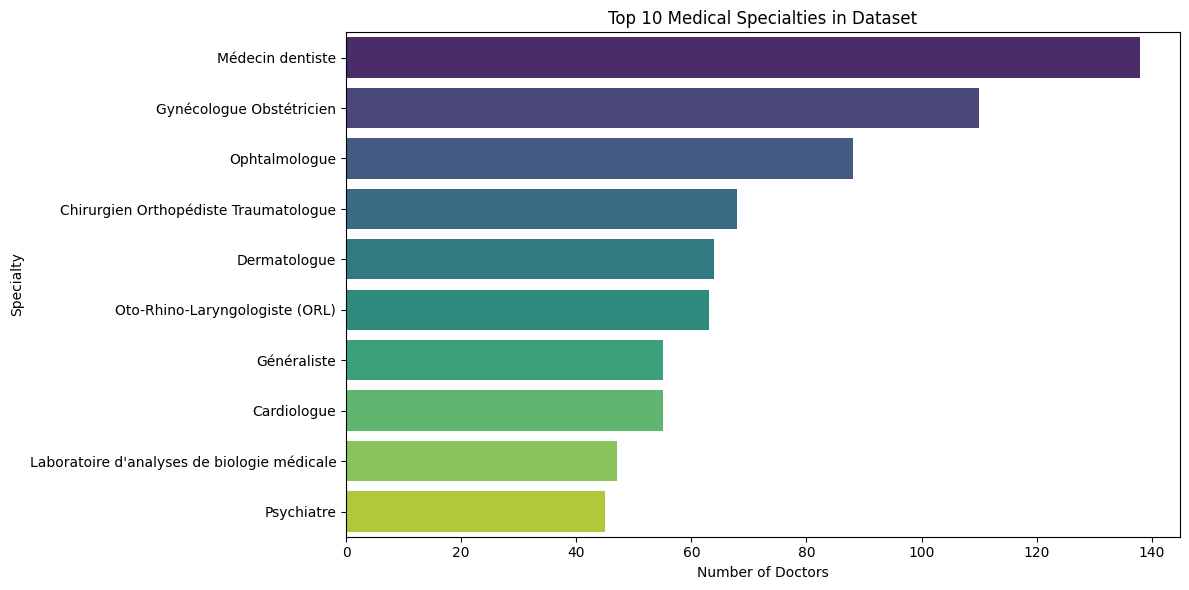

In [9]:
plt.figure(figsize=(12, 6))
top_specialties = df['specialty'].value_counts().head(10)
sns.barplot(x=top_specialties.values, y=top_specialties.index, hue=top_specialties.index, palette='viridis', legend=False)
plt.title('Top 10 Medical Specialties in Dataset')
plt.xlabel('Number of Doctors')
plt.ylabel('Specialty')
plt.tight_layout()
plt.savefig(os.path.join(script_dir, 'top_specialties.png'), dpi=300, bbox_inches='tight')
plt.show()

## 5. Visualization 2: Distribution by Estimated Region

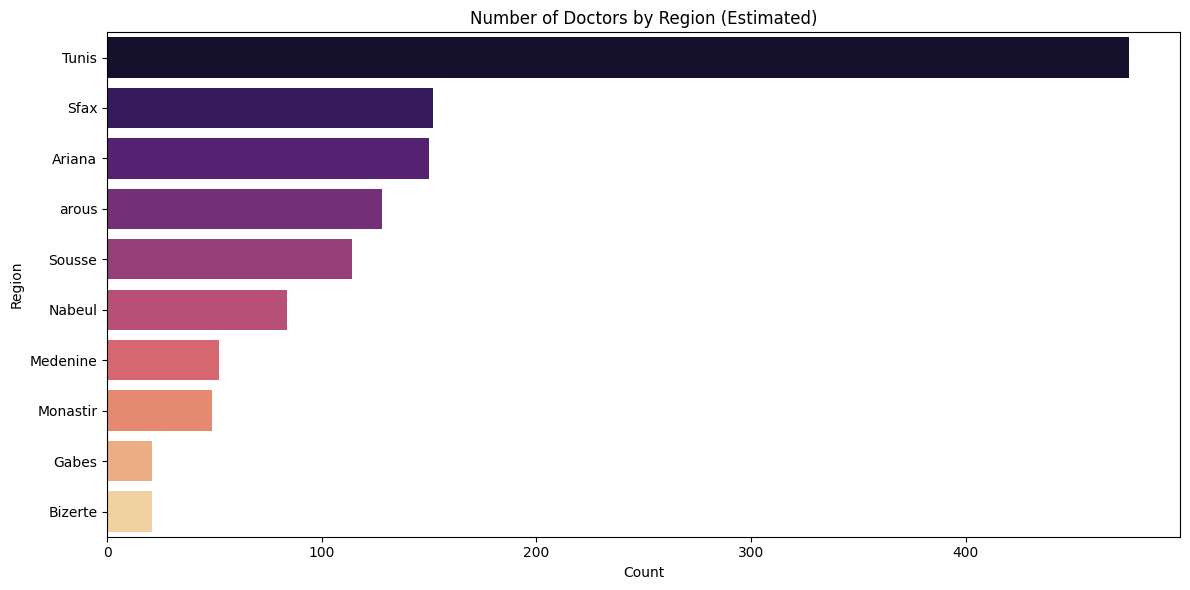

In [10]:
plt.figure(figsize=(12, 6))
top_regions = df['governorate_estimate'].value_counts().head(10)
sns.barplot(x=top_regions.values, y=top_regions.index, hue=top_regions.index, palette='magma', legend=False)
plt.title('Number of Doctors by Region (Estimated)')
plt.xlabel('Count')
plt.ylabel('Region')
plt.tight_layout()
plt.savefig(os.path.join(script_dir, 'doctors_by_region.png'), dpi=300, bbox_inches='tight')
plt.show()

## 6. Visualization 3: Interactive Map (Folium)

In [23]:
# Create a map centered on Tunisia
tunisia_map = folium.Map(location=[34.0, 9.5], zoom_start=7)

# Create a cluster to handle many markers cleanly
marker_cluster = MarkerCluster().add_to(tunisia_map)

# Iterate through the dataframe and add markers
for idx, row in df.iterrows():
    # Create popup text with Name and Specialty
    popup_text = f"""
    <b>{row['name']}</b><br>
    <i>{row['specialty']}</i><br>
    {row['address']}<br>
    <a href="{row['url']}" target="_blank">Voir Profil</a>
    """
    
    folium.Marker(
        location=[row['x'], row['y']], # x is Lat, y is Long based on your data
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color='blue', icon='user-md', prefix='fa')
    ).add_to(marker_cluster)

# Save map to an HTML file
map_path = os.path.join(script_dir, "doctors_map.html")
tunisia_map.save(map_path)
print(f"\nMap saved as '{map_path}'. Open this file in your browser to see the locations.")

# Display the map in the notebook
tunisia_map


Map saved as 'c:\Users\ghass\OneDrive\Desktop\practice projects\tutoré\scrape med data\visualisation\doctors_map.html'. Open this file in your browser to see the locations.


## 7. Simple Statistics

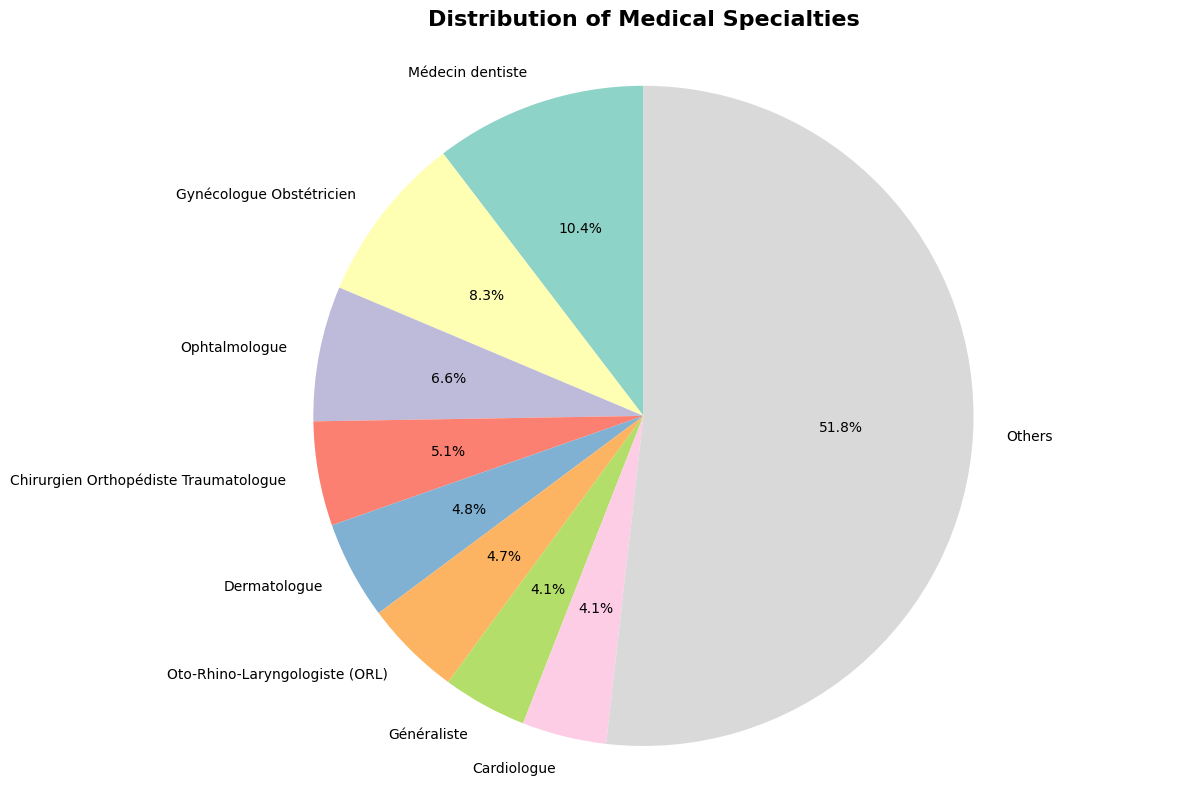

In [26]:
# Create a pie chart showing the top 8 specialties and group the rest as "Others"
plt.figure(figsize=(12, 8))

specialty_counts = df['specialty'].value_counts()
top_8 = specialty_counts.head(8)
others_sum = specialty_counts[8:].sum()

# Combine top 8 with Others
if others_sum > 0:
    pie_data = pd.concat([top_8, pd.Series({'Others': others_sum})])
else:
    pie_data = top_8

colors = plt.cm.Set3(range(len(pie_data)))
plt.pie(pie_data.values, labels=pie_data.index, autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'fontsize': 10})
plt.title('Distribution of Medical Specialties', fontsize=16, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.savefig(os.path.join(script_dir, 'specialty_distribution_pie.png'), dpi=300, bbox_inches='tight')
plt.show()

## 8. Visualization 4: Specialty Distribution (Pie Chart)

## 9. Save Processed Data

In [27]:
# Save the processed dataframe to CSV
output_path = os.path.join(script_dir, "processed_doctors_data.csv")
df.to_csv(output_path, index=False, encoding='utf-8')
print(f"Processed data saved to: {output_path}")
print(f"Total records saved: {len(df)}")

Processed data saved to: c:\Users\ghass\OneDrive\Desktop\practice projects\tutoré\scrape med data\visualisation\processed_doctors_data.csv
Total records saved: 1330
